In [1]:
## DO NOT MODIFY! 
## Import from previous notebook
import nbimporter
from p1 import cv2, np, plt, math, SimpleNamespace
from p1 import get_parameters, Gauss2D, filter_image_vec
from p2 import edge_detection_nms
from p3 import hough_transform, peak_hough_lines

image_list, constants = get_parameters()

#----------------------------------------------------------------------
# Different from visualize in p3, calls hough_accumulator_nms()
def visualize(image_name, constants):
    image_rgb = cv2.cvtColor(cv2.imread(image_name), cv2.COLOR_BGR2RGB)
    print("-" * 50 + "\n" + "Original Image:")
    plt.imshow(image_rgb); plt.show() # Displaying the sample image
    
    image = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)
    image_m, image_o, image_x, image_y = edge_detection_nms(image, constants.sigma)
    
    print("-" * 50 + "\n" + "Edge Image:")
    plt.imshow(image_m, cmap="gray"); plt.show() # Displaying the sample image
    
    image_m_thres = 1.0*(image_m > constants.thres) # threshold the edge magnitude image
    print("-" * 50 + "\n" + "Thresholded Edge Image:")
    plt.imshow(image_m_thres, cmap="gray"); plt.show() # Displaying the sample image
    
    #--------------hough transform----------------
    H, rho_arr, theta_arr = hough_transform(image_m, constants.thres, constants.rho_res, constants.theta_res)
    H = hough_accumulator_nms(H) # nms on H
    peak_rho_arr, peak_theta_arr = peak_hough_lines(H, rho_arr, theta_arr, constants.num_lines)
    
    #--------------vis----------------------------
    vis_line_len = 1000 # len of line in pixels, big enough to span the image
    vis_image_rgb = np.copy(image_rgb)
    for (rho, theta) in zip(peak_rho_arr, peak_theta_arr):
        x0 = rho*np.cos(theta); y0 = rho*np.sin(theta)
        x1 = int(x0 - vis_line_len*np.sin(theta)); y1 = int(y0 + vis_line_len*np.cos(theta))
        x2 = int(x0 + vis_line_len*np.sin(theta)); y2 = int(y0 - vis_line_len*np.cos(theta)); 
        cv2.line(vis_image_rgb, (x1, y1), (x2, y2), (0, 255, 0), 2)
    
    #---------------------------------------------
    print("-" * 50 + "\n" + "Edge Image:")
    plt.imshow(vis_image_rgb); plt.show() # Displaying the sample image
    
    return

### Q4.1 Non-Maximal Suppression for the Hough Accumulator (5 points)

Write a function that modifies the accumulator H suppressing the neighboring lines

```
  def hough_accumulator_nms(H):
        
        return H_prime

```

- **Input**: *$H$* is the accumulator matrix (rhos x thetas),
- **Output**: *$H\_prime$* is the suppressed accumulator matrix (rhos x thetas),

**Instructions**
- Often for every locally maximal cell in H, there will probably be its neighboring cells which also score highly. 
- We wish to avoid the selection of these neighboring cells using non maximal suppression.
- This NMS step is different than the edge magnitude NMS performed earlier. 
- Here you will consider all the 8 neighbors of the pixel, not just the pixels lying along the gradient direction.
- If for one of the neighbor, H[pixel] < H[neighbor] then set H_prime[pixel] = 0



In [2]:
def hough_accumulator_nms(H):
    """Compute Hough Transform for the image

    Args:
        image_m: np.array, HxW, edge magnitude image.
        
    Returns:
        image_m_prime: np.array, HxW, suppressed edge magnitude image.
    """
    H_prime = np.copy(H) 
    H_pad = np.pad(H, 1)
    neighbor_offsets = [(dy, dx) for dy in range(-1, 2) for dx in range(-1, 2) if (dy != 0 or dx != 0)]
    
    # compute supression mask per neighbour, 1 to suppress, 0 to keep
    # compare H and a part of H_pad, the part of H_pad can be obtained by moving H_pad using the neighbor_offsets
    # suppress_masks_per_neighbor = [? for (dy, dx) in neighbor_offsets]
    # YOUR CODE HERE
    for i in range(H.shape[0]):
        for j in range(H.shape[1]):
            f = 0
            for k in range(8):
                if H[i][j]>H_pad[i+1+neighbor_offsets[k][0]][j+1+neighbor_offsets[k][1]]:
                    f += 1
            if f == 8:
                H_prime[i][j] = H_prime[i][j]
            else:
                H_prime[i][j] = 0

    # raise NotImplementedError()
    
  #  suppress_mask = np.logical_or.reduce(suppress_masks_per_neighbor) # 1 to suppress, 0 to keep
  #  H_prime[suppress_mask] = 0
    
    return H_prime

### Q4.2 Line Segments for Visualization (15 points)

Write a function that visualizes the line segments (unlike the infinite lines from the function provided) on the image 
Note, this question will not be autograded but manually graded. Please submit the visualization of all 10 images into your writeup for full credit.

```
  def visualize_line_segments(image_name, constants):
        
        return vis_image_rgb

```

- **Input**: *$image\_name$* is the image path of input image, *$constants$ are the hyperparameters*.
- **Output**: *$vis\_image\_rgb$* is the visualized image containing line segments.

**Instructions**
- For each pixel, if it belongs to an edge, for all lines passing through the pixel, try fitting a fixed length small line segment centered at the pixel and match it with the line.
- If the pixel passes this check, draw the fixed small line segment on the image.

**Grading** Manually done for all the 10 images in the data folder.

In [3]:
def visualize_line_segments(image_name, constants):
    image_rgb = cv2.cvtColor(cv2.imread(image_name), cv2.COLOR_BGR2RGB)  
    image = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)
    image_m, image_o, image_x, image_y = edge_detection_nms(image, constants.sigma)
    vis_image_rgb = np.copy(image_rgb)
    
    #--------------hough transform----------------
    H, rho_arr, theta_arr = hough_transform(image_m, constants.thres, constants.rho_res, constants.theta_res)
    H = hough_accumulator_nms(H) # nms on H
    peak_rho_arr, peak_theta_arr = peak_hough_lines(H, rho_arr, theta_arr, constants.num_lines)
    
    image_m_thres = 1.0*(image_m > 30)
    rho=np.zeros(len(rho_arr))
    for i in range(1,vis_image_rgb.shape[0]-1):
        for j in range(1,vis_image_rgb.shape[1]-1):
            if image_m_thres[i][j]>0:
                for h in range(len(peak_theta_arr)):
                    rhot=i*math.cos(peak_theta_arr[h])+j*math.sin(peak_theta_arr[h])
                    if abs(peak_rho_arr[h]-rhot) < 110:
                    #if i!=0 or j!=0 or i!=vis_image_rgb.shape[0] or j!=vis_image_rgb.shape[1]:
                        for k in range(vis_image_rgb.shape[2]):
                            if image_o[i][j]==0:
                                vis_image_rgb[i][j][1]=200
                                vis_image_rgb[i+1][j][1]=200
                                vis_image_rgb[i-1][j][1]=200
                            elif image_o[i][j]==45:
                                vis_image_rgb[i][j][1]=200
                                vis_image_rgb[i+1][j+1][1]=200
                                vis_image_rgb[i-1][j-1][1]=200
                            elif image_o[i][j]==90:
                                vis_image_rgb[i][j][1]=200
                                vis_image_rgb[i][j+1][1]=200
                                vis_image_rgb[i][j-1][1]=200
                            elif image_o[i][j]==135:
                                vis_image_rgb[i][j][1]=200
                                vis_image_rgb[i+1][j-1][1]=200
                                vis_image_rgb[i-1][j+1][1]=200
                            elif image_o[i][j]==180:
                                vis_image_rgb[i][j][1]=200
                                vis_image_rgb[i+1][j][1]=200
                                vis_image_rgb[i-1][j][1]=200
                            elif image_o[i][j]==225:
                                vis_image_rgb[i][j][1]=200
                                vis_image_rgb[i+1][j+1][1]=200
                                vis_image_rgb[i-1][j+1][1]=200
                            elif image_o[i][j]==270:
                                vis_image_rgb[i][j][1]=200
                                vis_image_rgb[i][j+1][1]=200
                                vis_image_rgb[i][j-1][1]=200
                            elif image_o[i][j]==315:
                                vis_image_rgb[i][j][1]=200
                                vis_image_rgb[i+1][j-1][1]=200
                                vis_image_rgb[i-1][j+1][1]=200
                            else:
                                vis_image_rgb[i][j][1]=200
                                vis_image_rgb[i+1][j][1]=200
                                vis_image_rgb[i-1][j][1]=200
    
    # visualize line segments (not infinite lines!)
    # vis_image_rgb = ?
    
    # YOUR CODE HERE
    plt.imshow(vis_image_rgb)
    return image_rgb, vis_image_rgb
    # raise NotImplementedError()
    
    return image_rgb, vis_image_rgb

### Test Q4.1

In [ ]:
## TOY TEST!
# H = np.random.rand(5, 5)
# H_prime = hough_accumulator_nms(H)
# print(H); print(H_prime)

## Uncomment to visualize
# image_idx = np.random.randint(0, len(image_list))
# visualize(image_list[image_idx], constants)

[[0.79850001 0.22400476 0.48985886 0.26783956 0.83479562]
 [0.52971398 0.11783087 0.98737235 0.02343068 0.00731811]
 [0.26913762 0.16075279 0.85643494 0.47074041 0.48112439]
 [0.42238945 0.87628021 0.60828497 0.24616541 0.54345976]
 [0.14563941 0.30084048 0.34549316 0.37463971 0.76070884]]
[[0.79850001 0.         0.         0.         0.83479562]
 [0.         0.         0.98737235 0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.87628021 0.         0.         0.        ]
 [0.         0.         0.         0.         0.76070884]]
--------------------------------------------------
Original Image:


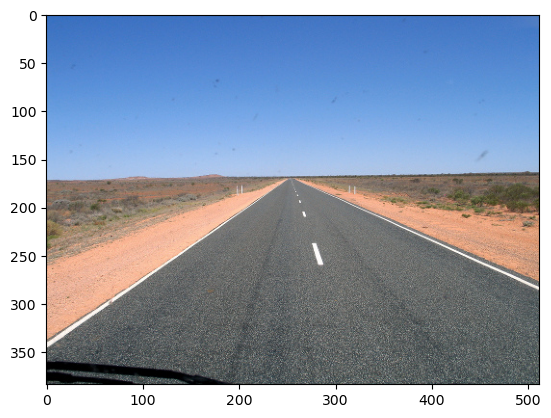

[[1. 1. 1. ... 1. 1. 1.]
 [1. 0. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 0. 1.]
 ...
 [1. 0. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 0. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
--------------------------------------------------
Edge Image:


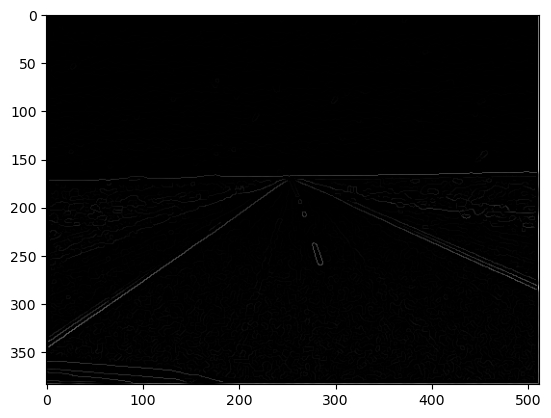

--------------------------------------------------
Thresholded Edge Image:


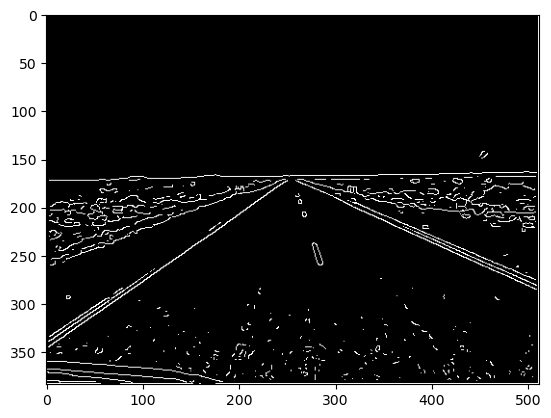

(array([   0,  847,  847, ..., 1151, 1023,  640], dtype=int64), array([  0, 157, 158, ...,   0,  90,  90], dtype=int64))
--------------------------------------------------
Edge Image:


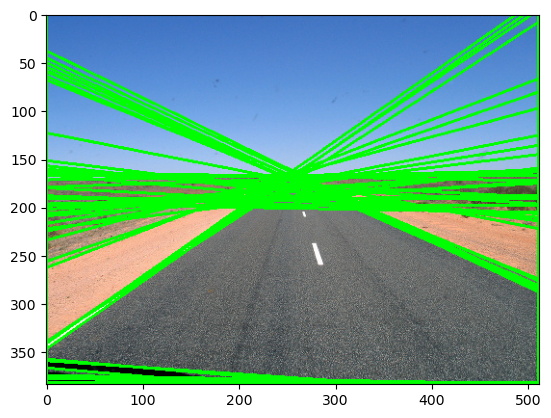

In [4]:
## TOY TEST!
H = np.random.rand(5, 5)
H_prime = hough_accumulator_nms(H)
print(H); print(H_prime)

## Uncomment to visualize
image_idx = np.random.randint(0, len(image_list))
visualize(image_list[image_idx], constants)
#visualize(image_list[9], constants)
#visualize_line_segments(image_list[9], constants)

### Test Q4.2

In [ ]:
# YOUR CODE HERE

### Autograde Q4.1
0.5 points per test case, 10 test cases

YOUR ANSWER HERE